# Shared Interest
## Example usage of Shared Interest

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL.Image
from sklearn.metrics import accuracy_score
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm

from shared_interest.datasets.imagenet import ImageNet
from shared_interest.shared_interest import shared_interest
from shared_interest.util import flatten, binarize_std
from interpretability_methods.vanilla_gradients import VanillaGradients

### Load Model
In this example, we will use a `resnet50` from PyTorch pretrained on ImageNet. 

In [3]:
def load_model_from_pytorch(architecture, pretrained):
    model = models.__dict__[architecture](pretrained=pretrained)
    return model

model = load_model_from_pytorch('resnet50', pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### Load Dataset
In this example, we are using ImageNet images. We assume that `imagnet_dir` contains two subfolders: `images` and `annotations`. Each subfolder is set up in PyTorch Image Folder style such that it contains a directory for each class and the images in that class are located in the sub folder. For instance, image `00001234.JPEG` that is in class `300` would be located in `imagenet_dir/images/0300/0001234.JPEG` and its annotation would be in `imagenet_dir/annotations/0300/00001243.xml`.

In [4]:
imagenet_dir = '/nobackup/users/aboggust/data/imagenet/imagenet/val'
image_dir = os.path.join(imagenet_dir, 'images')
annotation_dir = os.path.join(imagenet_dir, 'annotations')

In [5]:
# ImageNet transforms.
image_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                           std=[0.229, 0.224, 0.225]),
                                     ])

ground_truth_transform = transforms.Compose([transforms.ToPILImage(),
                                             transforms.Resize(256, PIL.Image.NEAREST),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor()])

reverse_image_transform = transforms.Compose([transforms.Normalize(mean=[0, 0, 0], 
                                                                   std=[4.3668, 4.4643, 4.4444]),
                                              transforms.Normalize(mean=[-0.485, -0.456, -0.406], 
                                                                   std=[1, 1, 1]),
                                              transforms.ToPILImage(),])

In [6]:
dataset = ImageNet(image_dir, annotation_dir, image_transform, ground_truth_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False, 
                                         num_workers=40, pin_memory=True)

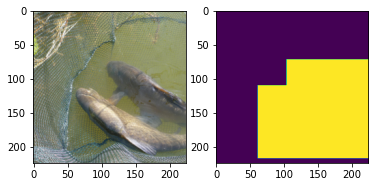

In [7]:
for image, ground_truth, label in dataset:
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(reverse_image_transform(image))
    ax[1].imshow(ground_truth)
    break

### Load Saliency Method
Many common saliency methods are implemented in `interpretability_methods`. Here, we use vanilla gradients. 

In [8]:
saliency_method = VanillaGradients(model)

### Run Shared Interest
We perform one pass through the data, computing the prediction, saliency, and Shared Interest scores along the way. For this efficiency in this example, we only look at the first 10 batches.

In [9]:
def run(model, dataloader, saliency_method, stop_after=None):
    """
    Runs the model through the data in the dataloader and computes the 
    predictions, saliency, and Shared Interest scores.
    
    Args:
    model: pytorch model to evaluate.
    dataloader: dataloader to evaluate the model on. Should output an image,
        ground truth, and label for each index.
    saliency_method: the InterpretabilityMethod to use to compute Shared
        Interest.
    stop_after: optional integer that determins when to stop the evaluation.
        Used here for efficiency in the notebook. If None, entire process will
        run.
    """
    model.eval()
    accuracy = 0
    total_shared_interest_scores = {'iou_coverage': np.array([]),
                                    'ground_truth_coverage': np.array([]),
                                    'saliency_coverage': np.array([]),}
    total_predictions = np.array([])
    total_saliency_masks = np.array([[[]]])
    for i, (images, ground_truth, labels) in enumerate(tqdm(dataloader)):
        with torch.no_grad():
            images = images.to(device)
            ground_truth = ground_truth.numpy()
            labels = labels.numpy()

            # Compute model predictions
            output = model(images)
            predictions = torch.argmax(output, dim=1).detach().cpu().numpy()
            total_predictions = np.concatenate((total_predictions, predictions))

            # Update metrics
            accuracy += accuracy_score(labels, predictions)
        
        # Compute saliency
        saliency = flatten(saliency_method.get_saliency(images))
        saliency_masks = binarize_std(saliency)
        if i == 0: 
            total_saliency_masks = saliency_masks
        else:
            total_saliency_masks = np.concatenate((total_saliency_masks, saliency_masks))
        
        # Compute Shared Interest scores
        for score in total_shared_interest_scores:
            shared_interest_scores = shared_interest(ground_truth, saliency_masks, score=score)
            total_shared_interest_scores[score] = np.concatenate((total_shared_interest_scores[score], shared_interest_scores))

        # Stop early for this example notebook
        if stop_after and stop_after == i:
            break
    accuracy /= i + 1
    print('Accuracy: %.2f' %accuracy)
    return total_saliency_masks, total_shared_interest_scores, total_predictions

In [10]:
saliency_masks, shared_interest_scores, predictions = run(model, dataloader, saliency_method, stop_after=9)

  0%|          | 0/391 [00:00<?, ?it/s]/nobackup/users/aboggust/bin/miniconda3/envs/wml/lib/python3.6/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
  2%|▏         | 9/391 [01:49<43:45,  6.87s/it]   

Accuracy: 0.90


### Explore the results
Let's take a look at some examples!

In [11]:
"""Code to visualize the Shared Interest results."""

def ax_off(ax):
    ax.tick_params(
        which='both',
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labeltop=False,
        labelleft=False,
        labelright=False,
    )

def display_images(data_inds, dataset):
    data = [dataset[i] for i in data_inds]
    n = len(data)
    fig, ax = plt.subplots(nrows=n, ncols=3, figsize=(10,4*n))
    np.vectorize(ax_off)(ax)
    
    for i, (image, ground_truth, label) in enumerate(data):
        data_ind = data_inds[i]
        ax[i][0].imshow(reverse_image_transform(image))
        ax[i][0].set_title('Image\nLabel: %s Pred: %s' %(label, int(predictions[data_ind])))

        masked_image = image * ground_truth.unsqueeze(0)
        ax[i][1].imshow(reverse_image_transform(masked_image))
        ax[i][1].set_title('Ground Truth\n')
        
        saliency_image = np.array(reverse_image_transform(image)) * np.expand_dims(saliency_masks[data_ind], axis=2)
        ax[i][2].imshow(saliency_image)
        ax[i][2].set_title('Saliency\nIoU: %.1f SC: %.1f GTC: %.1f'
                    %(shared_interest_scores['iou_coverage'][data_ind],
                      shared_interest_scores['saliency_coverage'][data_ind],
                      shared_interest_scores['ground_truth_coverage'][data_ind],
                     ))
    return fig

/nobackup/users/aboggust/bin/miniconda3/envs/wml/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 1279 + 1) instead
  """Entry point for launching an IPython kernel.


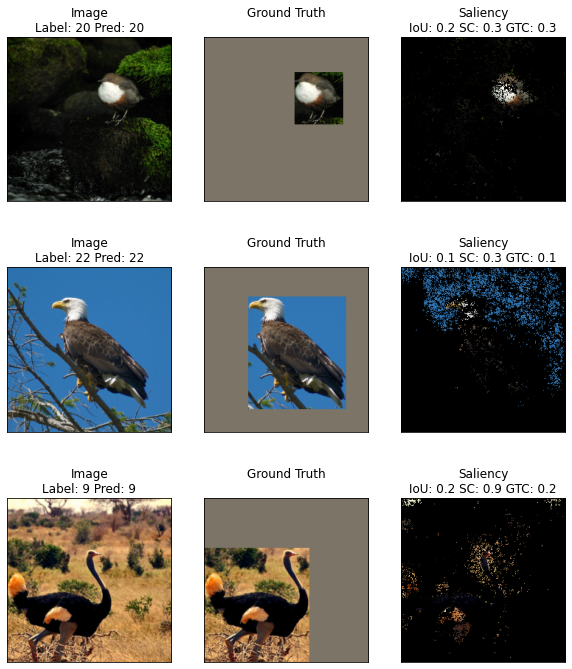

In [14]:
fig = display_images(np.random.random_integers(0, len(predictions)-1, 3), dataset)